In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math

BITS_NUM = 5
SAMPLES_PER_BIT_NUM = 5
E=1

In [16]:
def generate_random_bits(size = BITS_NUM):
    return np.random.choice(a=[0,1] , size= size)

def generate_signal(random_bits,samples_per_bit_num,duration):
    signal = np.ones((len(random_bits),samples_per_bit_num))
    for i in range (len(random_bits)):
        if random_bits[i] == 1:
            signal[i] = np.ones(int(samples_per_bit_num * duration))
        elif random_bits[i] == 0:
            signal[i] = np.full(int(samples_per_bit_num * duration), -1)
    return signal/math.sqrt(samples_per_bit_num)

def generate_gaussian_noise (sigma, size):
    return np.random.normal(loc = 0 ,scale=sigma, size=size)

def add_noise(signal,sigma,samples_per_bit_num = SAMPLES_PER_BIT_NUM):
    noise = generate_gaussian_noise(sigma = sigma, size=len(signal)*samples_per_bit_num)
    noisy_signal=np.copy(signal)
    for i in range(len(signal)):
        noisy_signal[i, :] +=noise[i*samples_per_bit_num:(i+1)*samples_per_bit_num]
    return noisy_signal

def calc_convolution(noisy_signal, filter):
    convolved = None
    convolved_sampled=np.zeros(noisy_signal.shape[0])
    if(filter is None): 
        convolved = noisy_signal.flatten()
    else:
        convolved = np.convolve(noisy_signal.flatten(), filter)

    for i in range(noisy_signal.shape[0]):
        convolved_sampled[i] =convolved[(noisy_signal.shape[1] - 1) + noisy_signal.shape[1] *i]
    
    convolved_sampled = (convolved_sampled > 0).astype(int)
    return convolved,convolved_sampled

def calc_sim_error(expected, received):
    return (np.sum(received != expected)) / len(expected)

def calc_theo_error(N,filter_type):
    if(filter_type==0 ): # matched 
        return (0.5 * math.erfc(1/(N ** 0.5)))
    
    if(filter_type==1): #ramp 
        return 0.5 * math.erfc((3 /N) ** 0.5 / 2)
    
    else: # none 
        return (0.5 * math.erfc((1/math.sqrt(SAMPLES_PER_BIT_NUM))/(N ** 0.5)))



In [17]:
    
def plot_filter_out(ax,noisy_signal,random_bits,filter,filter_type,N):
    convolved,convolved_sampled = calc_convolution(noisy_signal=noisy_signal , filter= filter)
    sim_error = calc_sim_error(random_bits,convolved_sampled)
    print("Prob of error for filter type ",filter_type," is ",sim_error)
    ax[filter_type].plot(range(0, convolved.flatten().shape[0]), convolved.flatten(), label = "bit value")
    for i in range(SAMPLES_PER_BIT_NUM - 1, convolved.flatten().shape[0], SAMPLES_PER_BIT_NUM):
        ax[filter_type].stem([i], [convolved.flatten()[i]], linefmt='magenta')
    ax[filter_type].set_xlabel('Time (s)')
    ax[filter_type].set_ylabel('Amplitude')
    if filter_type == 0:
        ax[filter_type].set_title(f'Matched Filter Output')
    elif filter_type == 1:
        ax[filter_type].set_title(f'Ramp Filter Output')
    else:
        ax[filter_type].set_title(f'No Filter Output')
    ax[filter_type].grid(True)

Signal  [0 1 0 0 0]
Prob of error for filter type  0  is  0.0
Prob of error for filter type  1  is  0.0
Prob of error for filter type  2  is  0.0


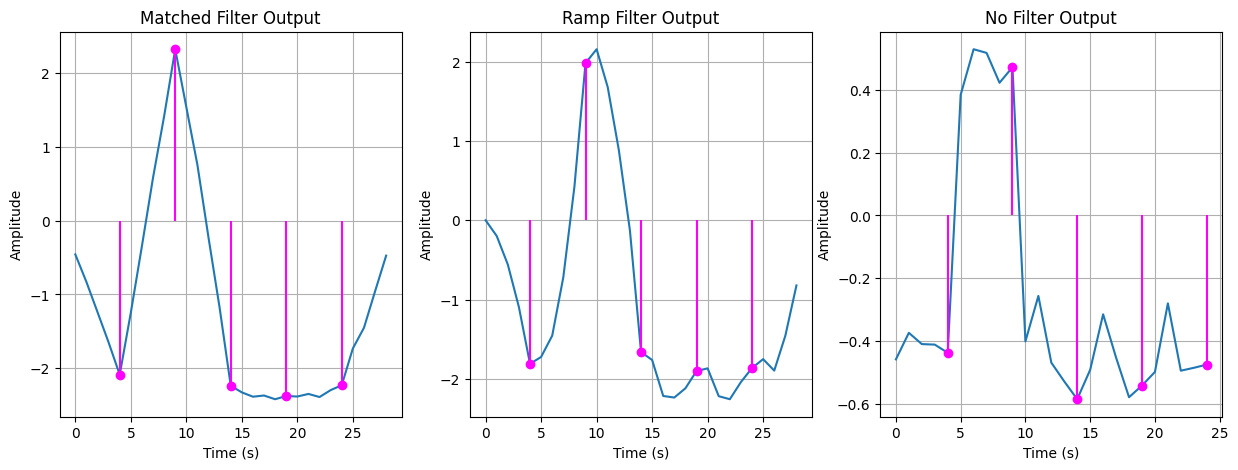

In [18]:
#testing
random_bits = np.array([0,1,0,0,0])
print("Signal ",random_bits)

E_over_N=10**(20/10)
N=E/E_over_N


signal=generate_signal(random_bits,SAMPLES_PER_BIT_NUM,1)
noisy_signal=add_noise(signal,np.sqrt(N/2),SAMPLES_PER_BIT_NUM)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))



#0 --> Matched
filter_matched=np.ones(SAMPLES_PER_BIT_NUM)
plot_filter_out (ax,noisy_signal , random_bits , filter_matched,0,N )


#1 --> Ramp
filter_ramp= np.linspace(0, 3**0.5, SAMPLES_PER_BIT_NUM)
plot_filter_out (ax,noisy_signal , random_bits , filter_ramp,1,N )

#2 --> None
plot_filter_out (ax,noisy_signal , random_bits , None,2,N )

plt.show()


In [19]:
#BER part

random_bits = generate_random_bits( size= 10**5)

matched_sim_BER,matched_theo_BER= [] , []
ramp_sim_BER,ramp_theo_BER= [] , []
none_sim_BER,none_theo_BER= [] , []

# Define a dictionary to store lists for each filter type
sim_BER_dict = {0: matched_sim_BER, 1: ramp_sim_BER, 2: none_sim_BER}
theo_BER_dict = {0: matched_theo_BER, 1: ramp_theo_BER, 2: none_theo_BER}

In [20]:
def calc_filter_error (random_bits , convolved_sampled ,filter_type,N):

    # filter_type represents the type of filter (0 for matched, 1 for ramp, 2 for none)
    sim_error = calc_sim_error(random_bits, convolved_sampled)
    theo_error = calc_theo_error(N, filter_type)

    # Append the errors to the corresponding lists based on the filter type
    sim_BER_dict[filter_type].append(sim_error)
    theo_BER_dict[filter_type].append(theo_error)

In [21]:
for E_over_N_db in range (-10,21,1):
    E_over_N=10**(E_over_N_db/10)
    N=E/E_over_N
    
    signal=generate_signal(random_bits,SAMPLES_PER_BIT_NUM,1)
    noisy_signal=add_noise(signal,np.sqrt(N/2),SAMPLES_PER_BIT_NUM)
    
    #0 --> Matched
    convolved,convolved_sampled=calc_convolution(noisy_signal,filter_matched)
    calc_filter_error(random_bits,convolved_sampled,0,N)
    
    #1 --> Ramp
  
    convolved,convolved_sampled = calc_convolution(noisy_signal,filter_ramp)
    calc_filter_error(random_bits,convolved_sampled,1,N)

    #2 --> None
    convolved,convolved_sampled=calc_convolution(noisy_signal,None)
    calc_filter_error(random_bits,convolved_sampled,2,N)


In [22]:
sim_BER_label_dict = {0: 'matched_sim_BER', 1: 'matched_sim_BER', 2: 'matched_sim_BER'}
theo_BER_label_dict = {0: 'matched_sim_BER', 1: 'matched_sim_BER', 2: 'matched_sim_BER'}

def plot_filter_BER(ax,filter_type):
    ax[filter_type].semilogy(range(-10,21), sim_BER_dict[filter_type] ,label=sim_BER_label_dict[filter_type])
    ax[filter_type].semilogy(range(-10,21), theo_BER_dict[filter_type] ,label=theo_BER_label_dict[filter_type])
    ax[filter_type].legend()
    ax[filter_type].set_xlabel('E/N0 (dB)') # X-axis label
    ax[filter_type].set_ylabel('BER') 
    if(filter_type == 0 ):
        ax[filter_type].set_title('BER vs. E/N0 (Matched Filter)')
    if(filter_type == 1 ):
        ax[filter_type].set_title('BER vs. E/N0 (Ramp Filter)')  
    else:
        ax[filter_type].set_title('BER vs. E/N0 (None Filter)') 
        
    ax[filter_type].set_ylim(10**(-4))
    ax[filter_type].grid(True) 



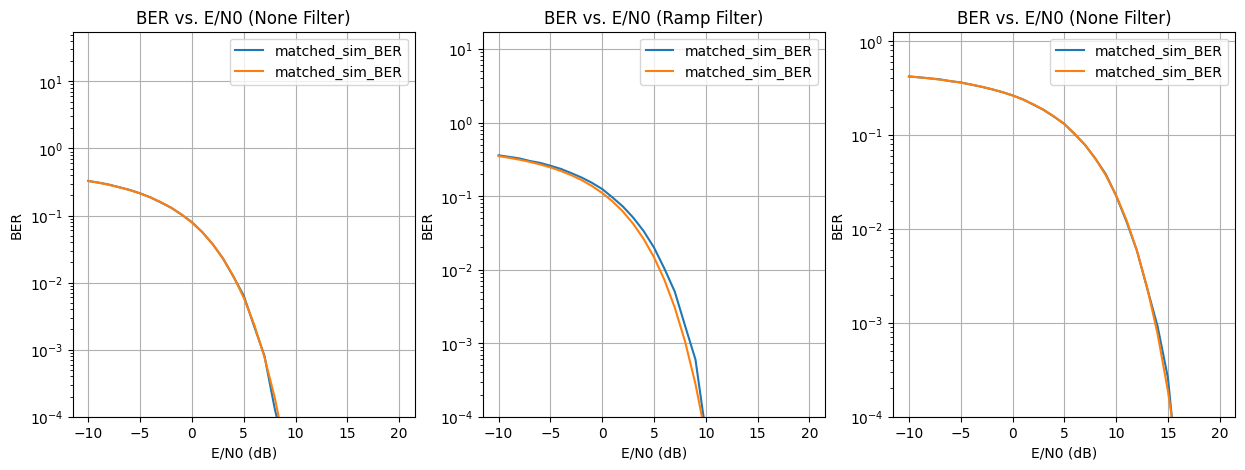

In [23]:

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_filter_BER(ax,0)
plot_filter_BER(ax,1)
plot_filter_BER(ax,2)
plt.show()


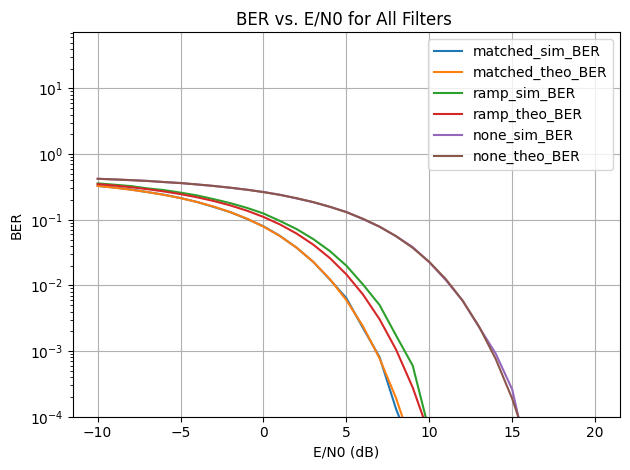

In [25]:
#plot all
plt.semilogy(range(-10,21), matched_sim_BER ,label='matched_sim_BER')
plt.semilogy(range(-10,21), matched_theo_BER,label='matched_theo_BER')
plt.semilogy(range(-10,21), ramp_sim_BER ,label='ramp_sim_BER')
plt.semilogy(range(-10,21), ramp_theo_BER,label='ramp_theo_BER')
plt.semilogy(range(-10,21), none_sim_BER ,label='none_sim_BER')
plt.semilogy(range(-10,21), none_theo_BER,label='none_theo_BER')
plt.legend()
plt.xlabel('E/N0 (dB)') # X-axis label
plt.ylabel('BER') 
plt.title('BER vs. E/N0 for All Filters ') 
plt.ylim(10**(-4))
plt.grid(True) 
plt.tight_layout()
plt.show()